# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements.txt

zsh:1: command not found: python


## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5),std=(0.5))
])

# Create training and validation set and define training and validation dataloader
train_data = torchvision.datasets.MNIST(root='data',download=True,train=True,transform=transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.MNIST(root='data',download=True,train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

## `ToTensor`

1. **Conversion to PyTorch Tensor**:
   - The `ToTensor()` transform converts images from PIL or NumPy format to PyTorch tensors. This conversion is necessary because PyTorch models operate on tensors. Tensors are multi-dimensional arrays that allow for efficient computation on GPUs, which is essential for training deep learning models.

2. **Scaling Pixel Values**:
   - This transform scales the pixel values from the range [0, 255] to [0, 1]. Neural networks perform better with input values in a consistent range, and scaling helps improve numerical stability and convergence during training.

## `Normalize`

1. **Standardization**:
   - The `Normalize((0.5), (0.5))` transform standardizes the pixel values by adjusting the mean and standard deviation. Normalizing with a mean and standard deviation of 0.5 scales the input images to the range [-1, 1]. This standardization helps the model to learn more efficiently, as the data is centered around zero and the values are in a consistent range.

## Benefits of Normalizing with Mean and Std = 0.5

 **Centered Data**:
   - By normalizing with a mean of 0.5, the data is centered around zero, which is optimal for many neural network architectures. This ensures that the activations are not too high or too low, which can help in faster and more stable convergence during training.




## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

0


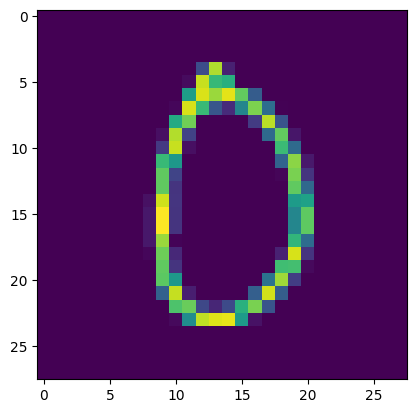

4


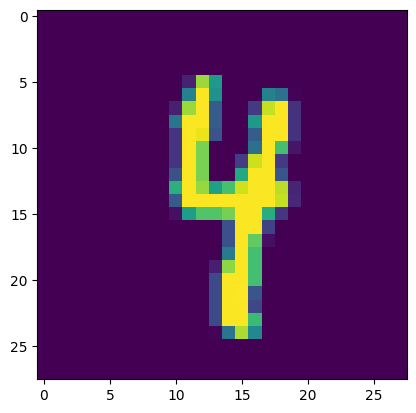

0


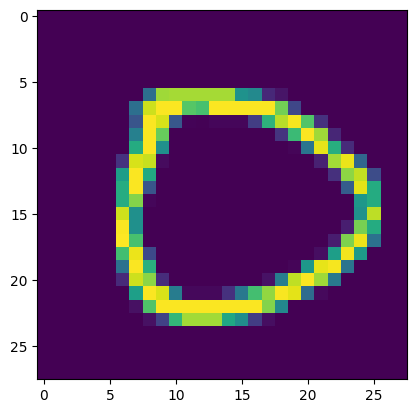

1


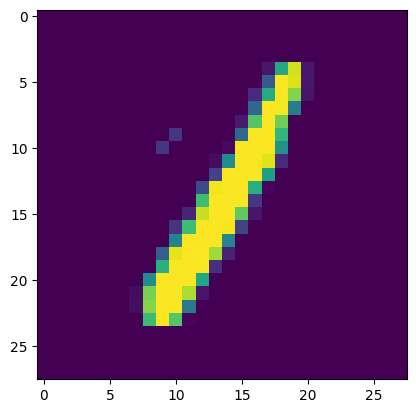

3


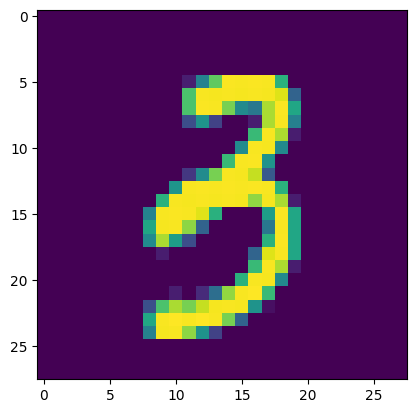

In [6]:
# Explore data
show5(train_loader)

## Explore the dimension of the dataset

In [7]:
sample_batch, _ = next(iter(train_loader))

# Get the shape of the sample batch
batch_shape = sample_batch.shape

print("Shape of a sample batch:", batch_shape)

Shape of a sample batch: torch.Size([32, 1, 28, 28])


In [8]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [9]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

In [10]:
data_iter = iter(train_loader)
image , label = next(data_iter)
image.shape

torch.Size([32, 1, 28, 28])

In [11]:
label.shape

torch.Size([32])

In [12]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28*28,128)
        self.fc2 = nn.Linear(128 , 64)
        self.fc3 = nn.Linear(64 , 10)
    def forward(self,x):
        x_flatten = torch.flatten(x,1)
        a1 = self.activation(self.fc1(x_flatten))
        a2 = self.activation(self.fc2(a1))
        a3 = self.fc3(a2)
        return a3
net = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [15]:
def print_stats(epoch,avg_loss,accuracy,phase):
    print(f'Epoch {epoch}, In {phase} phase : Accuracy is : {accuracy*100:0.2f} , Loss is {avg_loss:0.5f}')

In [16]:
def training_network(net,epochs,train_loader,val_loader,loss_hist,optimizer,criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    for epoch in range(1,1+epochs):
        for phase in ['training','validation']:
            total_loss = 0.0
            total_corrects = 0.0
            if phase == 'training':
                net.train()
                data_loader = train_loader
            else :
                net.eval()
                data_loader = val_loader
            for idx,[inputs,labels] in enumerate(data_loader):
                inputs,labels = inputs.to(device),labels.to(device)
                if phase == 'training':
                    optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs,labels)
                if phase == 'training':
                    loss.backward()
                    optimizer.step()
    
                _,pred = torch.max(outputs.data,1)
                total_corrects += (pred == labels).sum().item()
                total_loss += loss.item()
            if phase == 'training':
                num_samples = train_size
            else : 
                num_samples = val_size
            num_batches = len(data_loader)
        
            avg_loss = total_loss / num_batches
            accuracy = total_corrects / num_samples
        
            print_stats(epoch,avg_loss,accuracy,phase)
            loss_hist[phase].append(avg_loss) 

In [17]:
epochs = 10
loss_hist = {
    'training':list(),
    'validation':list()
}
training_network(net,epochs,train_loader,val_loader,loss_hist,optimizer,criterion)

Epoch 1, In training phase : Accuracy is : 88.50 , Loss is 0.38016
Epoch 1, In validation phase : Accuracy is : 92.84 , Loss is 0.23522
Epoch 2, In training phase : Accuracy is : 94.36 , Loss is 0.18567
Epoch 2, In validation phase : Accuracy is : 94.81 , Loss is 0.16591
Epoch 3, In training phase : Accuracy is : 95.69 , Loss is 0.14203
Epoch 3, In validation phase : Accuracy is : 96.10 , Loss is 0.12737
Epoch 4, In training phase : Accuracy is : 96.42 , Loss is 0.11446
Epoch 4, In validation phase : Accuracy is : 96.43 , Loss is 0.12309
Epoch 5, In training phase : Accuracy is : 96.81 , Loss is 0.10151
Epoch 5, In validation phase : Accuracy is : 96.80 , Loss is 0.10625
Epoch 6, In training phase : Accuracy is : 97.14 , Loss is 0.08890
Epoch 6, In validation phase : Accuracy is : 96.39 , Loss is 0.12254
Epoch 7, In training phase : Accuracy is : 97.51 , Loss is 0.07645
Epoch 7, In validation phase : Accuracy is : 96.85 , Loss is 0.10699
Epoch 8, In training phase : Accuracy is : 97.68

Plot the training loss (and validation loss/accuracy, if recorded).

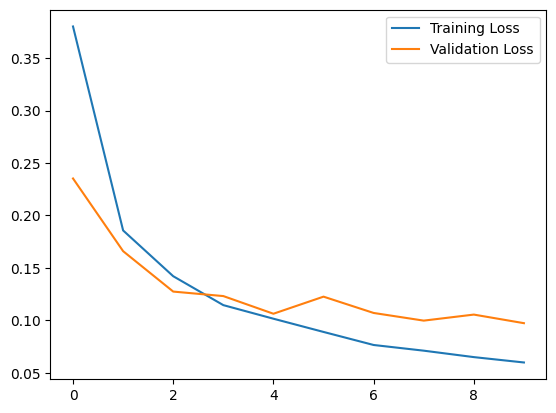

In [18]:
# Plot the training and validation loss history
plt.plot(loss_hist["training"], label="Training Loss")
plt.plot(loss_hist["validation"], label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [19]:
def testing_network(net,test_loader,criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    test_loss = 0.0
    test_corrects = 0
    
    net.eval()
    
    with torch.no_grad():
        for inputs,labels in test_loader:
            inputs , labels = inputs.to(device), labels.to(device)
            
            outputs=net(inputs)
            loss = criterion(outputs,labels)
        
            _,pred = torch.max(outputs.data,1)
            test_corrects += (pred == labels).sum().item()
            test_loss += loss.item()
    num_samples = test_loader.dataset.data.shape[0]
    num_batches = len(test_loader)
    
    avg_loss = test_loss / num_batches
    accuracy = test_corrects / num_samples
    
    print(f"The Final Test Loss is : {avg_loss:0.4f}")
    print(f"Test Accuracy is : {accuracy*100:0.2f}")

In [20]:
testing_network(net,test_loader,criterion)

The Final Test Loss is : 0.0947
Test Accuracy is : 97.18


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

### First i can improve the performance by calculating the exact mean and std of this dataset :

In [21]:
# Define a transform to convert the images to tensors
transform2 = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
train_dataset2 = torchvision.datasets.MNIST(root='data',download=False,train=True,transform=transform2)

# Create a DataLoader to iterate through the dataset
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=60000, shuffle=False)

# Get all the images in a single batch
data_iter = iter(train_loader2)
images, labels = next(data_iter)

# Compute the mean and std
mean = images.mean()
std = images.std()

In [22]:
mean.item()

0.13066047430038452

In [23]:
std.item()

0.30810782313346863

In [24]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean.item()),std=(std.item()))
])
# Create training and validation set and define training and validation dataloader
train_data = torchvision.datasets.MNIST(root='data',download=True,train=True,transform=transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.MNIST(root='data',download=True,train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32)

## I can try another architecture to the net !! by adding dropout to avoid overfitting and change the layers 

In [25]:
class Net(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super().__init__()
        self.activation = F.relu
        self.dropout_prob = dropout_prob
        
        self.fc1 = nn.Linear(28*28, 256)  
        self.fc2 = nn.Linear(256, 128)    
        self.fc3 = nn.Linear(128, 64)    
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.dropout3 = nn.Dropout(p=dropout_prob)
    
    def forward(self, x):
        x_flatten = torch.flatten(x, 1)
        
        a1 = self.activation(self.fc1(x_flatten))
        a1_drop = self.dropout1(a1)
        
        a2 = self.activation(self.fc2(a1_drop))
        a2_drop = self.dropout2(a2)
        
        a3 = self.activation(self.fc3(a2_drop))
        a3_drop = self.dropout3(a3)
        
        a4 = self.fc4(a3_drop)
        
        return a4

net = Net()

## By using another optimizer like SGD and use momentum to avoid overfitting 

In [26]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

## Train the new net with new parameters !! 

In [27]:
epochs = 10
loss_hist = {
    'training':list(),
    'validation':list()
}

In [28]:
training_network(net,epochs,train_loader,val_loader,loss_hist,optimizer,criterion)

Epoch 1, In training phase : Accuracy is : 78.72 , Loss is 0.68897
Epoch 1, In validation phase : Accuracy is : 93.83 , Loss is 0.22249
Epoch 2, In training phase : Accuracy is : 90.49 , Loss is 0.35691
Epoch 2, In validation phase : Accuracy is : 95.15 , Loss is 0.16795
Epoch 3, In training phase : Accuracy is : 92.24 , Loss is 0.28911
Epoch 3, In validation phase : Accuracy is : 95.87 , Loss is 0.14443
Epoch 4, In training phase : Accuracy is : 93.20 , Loss is 0.26250
Epoch 4, In validation phase : Accuracy is : 96.33 , Loss is 0.13600
Epoch 5, In training phase : Accuracy is : 93.50 , Loss is 0.25110
Epoch 5, In validation phase : Accuracy is : 96.63 , Loss is 0.12442
Epoch 6, In training phase : Accuracy is : 94.04 , Loss is 0.22834
Epoch 6, In validation phase : Accuracy is : 96.61 , Loss is 0.12406
Epoch 7, In training phase : Accuracy is : 94.21 , Loss is 0.21897
Epoch 7, In validation phase : Accuracy is : 96.83 , Loss is 0.11670
Epoch 8, In training phase : Accuracy is : 94.60

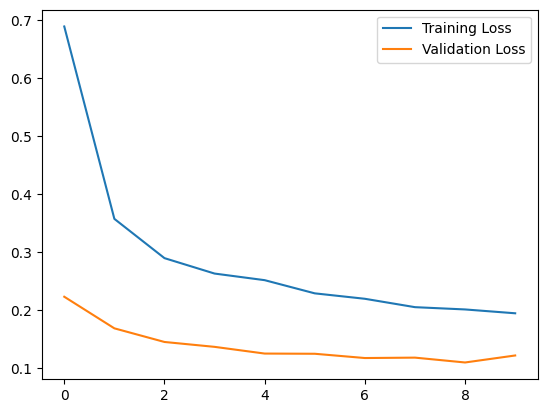

In [29]:
# Plot the training and validation loss history
plt.plot(loss_hist["training"], label="Training Loss")
plt.plot(loss_hist["validation"], label="Validation Loss")
plt.legend()
plt.show()

## Testing the new Model 

In [30]:
testing_network(net,test_loader,criterion)

The Final Test Loss is : 0.1212
Test Accuracy is : 96.95


## Saving your model
Using `torch.save`, save your model for future loading.

In [31]:
# Save the trained model
torch.save(net.cpu().state_dict(), "model.pth")